## 집값 예측 경진대회 베이스라인
이번 대회는 집의 면적, 상태, 퀄리티 등의 다양한 정보들을 통해 집값을 예측하는 대회입니다.

언뜻보면 간단해 보이지만 처음 데이터 분석을 접하시는 분들에게는 어디부터 어떻게 시작해야 하는지 막막하실 겁니다.

## 데이터 불러오기
먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

In [152]:
import pandas as pd

train = pd.read_csv("./train.csv")

print(f'train set은 {train.shape[1]} 개의 feature를 가진 {train.shape[0]} 개의 데이터 샘플로 이루어져 있습니다.')

train.head()

train set은 24 개의 feature를 가진 3000 개의 데이터 샘플로 이루어져 있습니다.


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,...,4,5,4,4,4,5,4,0,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,...,5,5,4,2,1,5,2,18,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,...,4,4,4,4,5,4,3,0,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,...,3,2,4,5,3,4,3,10,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,...,4,4,4,4,4,4,5,0,0.0,1


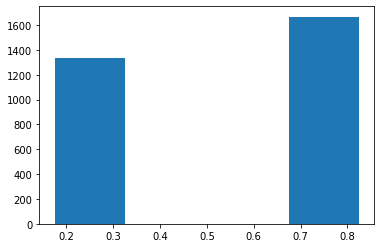

In [153]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(train['target'], bins=2, rwidth=0.3)
plt.show()

데이터를 자세히 살펴보는 것은 EDA 글을 통해 더 자세히 배워봅시다.

여기에서는 분석 방법에 초점을 맞추겠습니다.

## 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [154]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [155]:
train.info() #대체

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

이번 데이터에는 결측치가 존재하지 않네요.

만약 결측치가 존재한다면 결측치 삭제, 평균 보간법, 최빈값 보간법 등 다양한 방식으로 처리할 수 있습니다

## 데이터 전처리 

### 라벨 인코딩

데이터를 모델에 투입하기 전 몇 가지 전처리 과정이 필요합니다. 

우선은 카테고리 형식의 features 들을 바꿔주어야 합니다. 

본 데이터에서는 'Gender', 'Customer Type','Type of Travel', 'Class' 의 카테고리 형식의 feature 들이 있습니다. 

이러한 데이터의 라벨을 숫자로 바꾸어주는 전처리를 라벨 인코딩 (label encoding) 이라고 합니다.

본격적으로 데이터 전치리를 하기 전에 id 열을 제거해주고, data 와 target 을 나누어줍니다.

In [156]:
train_x = train.drop(["id","target"],axis=1) 
train_y = train.target 

#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

# train 데이터 라벨 인코딩
label_map = make_label_map(train_x) # train 사용해 label map 생성
train_x = label_encoder(train_x, label_map) # train 라벨 인코딩

train_x.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,1,22,1,1,1599,3,0,3,3,...,4,4,5,4,4,4,5,4,0,0.0
1,1,2,37,1,2,2810,2,4,4,4,...,3,5,5,4,2,1,5,2,18,18.0
2,2,2,46,1,2,2622,1,1,1,1,...,5,4,4,4,4,5,4,3,0,0.0
3,1,1,24,1,1,2348,3,3,3,3,...,3,3,2,4,5,3,4,3,10,2.0
4,1,2,58,1,2,105,3,3,3,3,...,5,4,4,4,4,4,4,5,0,0.0


In [157]:
train_x.loc[train_x['Seat comfort']<=2, 'new Seat comfort'] = 0
train_x.loc[train_x['Seat comfort']>=3, 'new Seat comfort'] = 1

del train_x['Seat comfort']

print(train_x['new Seat comfort'].value_counts())

1.0    1763
0.0    1237
Name: new Seat comfort, dtype: int64


In [158]:
train_x.loc[train_x['Age']<=20, 'new Age'] = 0
train_x.loc[(train_x['Age']>=40)&(train_x['Age']<20), 'new Age'] = 1
train_x.loc[(train_x['Age']>=40)&(train_x['Age']<50), 'new Age'] = 2
train_x.loc[train_x['Age']>=50, 'new Age'] = 3

del train_x['Age']

print(train_x['new Age'].value_counts())

3.0    832
2.0    659
0.0    340
Name: new Age, dtype: int64


In [159]:
train_x.loc[train_x['Flight Distance']<=2000, 'new Flight Distance'] = 0
train_x.loc[train_x['Flight Distance']>=2000, 'new Flight Distance'] = 1

del train_x['Flight Distance']

print(train_x['new Flight Distance'].value_counts())

0.0    1602
1.0    1398
Name: new Flight Distance, dtype: int64


In [160]:
train_x.loc[train_x['Departure Delay in Minutes']==0, 'new Departure Delay in Minutes'] = 0
train_x.loc[train_x['Departure Delay in Minutes']>0, 'new Departure Delay in Minutes'] = 1

del train_x['Departure Delay in Minutes']

print(train_x['new Departure Delay in Minutes'].value_counts())

0.0    1705
1.0    1295
Name: new Departure Delay in Minutes, dtype: int64


In [161]:
train_x.loc[train_x['Arrival Delay in Minutes']==0, 'new Arrival Delay in Minutes'] = 0
train_x.loc[train_x['Arrival Delay in Minutes']>0, 'new Arrival Delay in Minutes'] = 1

del train_x['Arrival Delay in Minutes']

print(train_x['new Arrival Delay in Minutes'].value_counts())

0.0    1661
1.0    1339
Name: new Arrival Delay in Minutes, dtype: int64


라벨 인코딩 후 원래 문자열 형식의 데이터가 숫자로 표현되어 있음을 볼 수 있습니다.

## 정규화 

수치형 데이터들을 정규화 시켜줍니다.

머신러닝 과정에서 모델은 데이터의 특성(feature)들을 추출해 학습을 진행합니다.

하지만 학습을 하는 과정에서 데이터의 값이 너무 크거나, 분산이 너무 크면 학습 과정에 악영향을 끼칠 수 있습니다.

따라서 정규화를 통해 데이터 값의 크기를 줄이고 분산을 줄여 모델이 데이터를 이상하게 해석하는 것을 방지합니다.

이번 베이스라인에서는 min-max 정규화를 이용해 봅시다.

min-max 정규화는 수치형 데이터의 값을 0~1 사이의 값으로 변환해줍니다.

min-max 정규화의 수식은 아래와 같습니다.

X' = (X - MIN) / (MAX-MIN)

In [162]:
from sklearn.preprocessing import MinMaxScaler

#num_features = ['Departure Delay in Minutes','Arrival Delay in Minutes']

#scaler = MinMaxScaler()
#train_x[num_features] = scaler.fit_transform(train_x[num_features]) 
train_x.head()

,Gender,Customer Type,Type of Travel,Class,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,new Seat comfort,new Age,new Flight Distance,new Departure Delay in Minutes,new Arrival Delay in Minutes
0,1,1,1,1,0,3,3,4,3,4,...,4,4,4,5,4,1.0,NaN,0.0,0.0,0.0
1,1,2,1,2,4,4,4,1,4,3,...,4,2,1,5,2,0.0,NaN,1.0,1.0,1.0
2,2,2,1,2,1,1,1,4,5,5,...,4,4,5,4,3,0.0,2.0,1.0,0.0,0.0
3,1,1,1,1,3,3,3,3,3,3,...,4,5,3,4,3,1.0,NaN,1.0,1.0,1.0
4,1,2,1,2,3,3,3,4,4,5,...,4,4,4,4,5,1.0,3.0,0.0,0.0,0.0


정규화 후 수치형 데이터들의 값이 0과 1 사이의 값으로 변환 되었음을 볼 수 있습니다.

## 모델 설계 

### Sigmoid Function

이번 베이스라인에서 사용할 모델은 Logistic Regression 입니다. 

Logistic Regression 의 기초가 되는 요소는 Sigmoid 함수 입니다. 

Sigmoid 함수는 입력 값을 받아 0 과 1 사이의 값을 출력하는 합수 입니다. 

#### sigmoid(z) = 1 / 1 + exp(-z)


Logistic Regression 모델에서의 입력 값을 z 라고 하겠습니다. 

이때 z 는 데이터의 feature(x) 들과 학습을 통해 정해진 weights(w) 들로 이루어져 있습니다.

#### z = x1 * w1 + x2 * w2 + ... + xn * wn  

Logostic Regression 모델은 이러한 z 를 입력 값으로 받아, Sigmoid 함수에 입력해 0 과 1 사이의 값을 출력하는 모델입니다.

이때 threshold 0.5 기준으로 0 또는 1 의 값을 출력합니다.

이때 모델이 학습하는 것은 데이터의 feature 들에 따른 weights 들 입니다. 

우선 학습 이전 최초의 weights 들은 랜덤한 값으로 정해집니다. 

그 후 학습을 통해 Loss Function 의 결과가 최소가 되는 방향으로 weights 들이 수정됩니다. 

### Loss Functinon

이때 Loss Function 은 실재 값과 모델이 예측한 값의 거리를 출력하는 함수 입니다. 

쉽게 말해 Loss Function 은 모델의 예측이 얼마나 틀렸는지를 알려주는 함수 입니다.

이 때 "모델의 예측이 얼마나 틀렸는지" 를 어떻게 정의하느냐에 따라 어떤 Loss Function 을 사용할 지가 정해집니다.

이번 베이스라인에서는 CrossEntropy Loss Function 을 사용해 보도록 하겠습니다.

#### Ly' = -log(y')  if y=1 else -log(1-y') 

### Gradient Desent

이제 Loss Function 을 최소화할 방법이 필요 합니다. 

다시 말해 어떠한 방식을 활용해 Loss Function 의 결과가 최소화되는 입력값 weights 를 찾을지 생각해 보아야 합니다.

머신러닝에서 이러한 과정을 "학습" 이라고 합니다.

Logistic Regression 모델은 gradient descent 라는 방식으로 학습을 합니다. 

미분을 통해 특정 weights 가 Loss Function 에 입력 되었을 때, 함수 상 그 지점에서의 기울기를 알 수 있습니다.

기울기를 통해 어느 방향으로 weights 를 수정해야 Loss Function 상에서 더 낮은 지점으로 나아갈 수 있는지 알 수 있습니다.

### Learning Rate

이때 특정 방향으로 얼마나 움직일지 결정하는 요인이 Learning Rate 입니다. 

Learning Rate 이 작을 수록 weights 를 조금씩 수정해 Loss Function 상에서 조금 씩 이동하겠다는 의미입니다.

epochs 는 학습 과정에서 총 몇번을 이동해야할지 결정하는 요인입니다.

In [163]:
import numpy as np
import tensorflow as tf

np.random.seed(1)

class LogisticRegression:
    
    # sigmoid 함수를 생성합니다
    def sigmoid(self, z): 
        return 1 / (1 + np.exp(-z))
    
    # lossfucntion 을 생성합니다
    def loss_function(self, X, y, weights): 
        total = len(X)
        z = np.dot(X, weights)
        prediction1 = y * np.log(self.sigmoid(z))
        prediction2 = (1 - y) * np.log(1 - self.sigmoid(z))
        return -sum(prediction1 + prediction2) / total
    
    #gradient decent 방법을 이용해 학습 함수를 생성합니다
    #learning rate 와 epochs 파라미터를 지정합니다
    def fit(self, X, y, epochs=1000, lr=0.02):        
        loss = []
        weights = np.random.rand(X.shape[1])
        total = len(X)
                 
        for epoch in range(epochs):        
            y_hat = self.sigmoid(np.dot(X, weights))
            weights = weights - (lr * np.dot(X.T,  y_hat - y) / total)      
            loss.append(self.loss_function(X, y, weights)) 
            
        self.weights = weights
        self.loss = loss

    def predict(self, X):
        z = np.dot(X, self.weights)
        result = self.sigmoid(z)
        return result
    
    def to_bin(self,result):
        arr=[]
        for i in result:
            if i >0.5:
                arr.append(1)
            else : 
                arr.append(0)
        return arr

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(22,)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

## 모델 학습

모델을 설계했으니 이제 모델을 학습하면 됩니다.

객체에 Logistic Regression 클래스를 할당 후, 클래스 내 fit 메소드를 이용해 학습을 진행하면 됩니다.

In [164]:
lr = LogisticRegression()
lr.fit(train_x,train_y)

In [165]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               2944      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 13,825
Trainable params: 13,825
Non-trainable params: 0
_________________________________________________________________


In [166]:
history=model.fit(train_x, train_y, epochs=500, batch_size=32, validation_split=0.25)

Epoch 1/500
21/71 [=======>......................] - ETA: 0s - loss: 0.2619

2022-02-07 16:52:02.894897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


65/71 [==========================>...] - ETA: 0s - loss: 0.2557

2022-02-07 16:52:03.394751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 10ms/step - loss: 0.2556 - val_loss: 0.2587
Epoch 2/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2512 - val_loss: 0.2522
Epoch 3/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2502 - val_loss: 0.2469
Epoch 4/500
71/71 [==============================] - 0s 5ms/step - loss: 0.2504 - val_loss: 0.2469
Epoch 5/500
71/71 [==============================] - 0s 5ms/step - loss: 0.2479 - val_loss: 0.2482
Epoch 6/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2504 - val_loss: 0.2475
Epoch 7/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2484 - val_loss: 0.2474
Epoch 8/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2479 - val_loss: 0.2469
Epoch 9/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2491 - val_loss: 0.2479
Epoch 10/500
71/71 [==============================] - 0s 6ms/step - loss: 0.2483 - val_loss: 0.2469
Epoch 11/500
71/71 [

KeyboardInterrupt: 

## 추론

모델을 학습했으니 test 데이터를 예측하는 일만 남았습니다! 

test 데이터에도 train 데이터에 했던 전처리를 진행한 후, 추론을 진행하면 됩니다.(data leakage 에 주의하도록 합니다!)

In [ ]:
test = pd.read_csv('./test.csv')
test = test.drop(["id"],axis=1) 

test = label_encoder(test, label_map) #test data 라벨 인코딩

test[num_features] = scaler.transform(test[num_features]) #test 데이터 정규화

LogisticRegression.predict() 는 Sigmoid Function 의 출력 값을 출력합니다.

따라서 예측 값들을 threshold 0.5 기준으로 0 또는 1 의 값으로 변환해주어야 합니다. 

In [ ]:
pred =model.predict(test)
pred_bin = pred.argmax(axis=-1)

In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')

sample_submission.target = pred_bin
sample_submission.to_csv("submission.csv",index=False)

## 축하합니다! 데이터 분석을 완료하셨습니다!

데이터들 사이의 관계를 찾아서, 그 관계를 통해 주어지지 않은 정보를 예측할 뿐입니다.

고도의 기술을 사용하면 이 예측값이 조금 더 정확해질뿐, 기본적인 개념은 바뀌지 않습니다.

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.